In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Librairies Import and Data Loading



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from tqdm import tqdm
import sklearn
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')
# Split the data into a prompt tuning set and an evaluation benchmark set
prompt_tuning_data, eval_data = train_test_split(data, test_size=0.9, random_state=42)

## Model, Tokenizer and Prompt Techniques 
**Add Prefix:** One simple technique is to add a fixed prefix to each input text. For example,adding the prefix "Classify this tweet as real disaster or not: " to each tweet text before feeding it into the language model.

**Add Location:** This technique appends the location of the tweet (if available) to the text of the tweet, separated by a space.For example, you could add the location "New York: " to a tweet that was sent from New York.

**Add Keyword:** This technique appends the keyword of the tweet (if available) to the text of the tweet, separated by a space. For example, if a tweet is tagged with the keyword "emergency", you could add the prefix "Emergency tweet: " to the tweet text.

In [ ]:
# Define the BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a list of prompt engineering techniques to test
prompt_techniques = ['add_prefix', 'add_location', 'add_keyword']

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Define a function to generate prompts using the specified technique
def generate_prompt(row, technique):
    prompt = ""
    if technique == 'add_prefix':
        prompt = "Is this tweet about a real disaster? " + row['text']
    elif technique == 'add_location':
        prompt =  str(row['location']) + " " + row['text']
    elif technique == 'add_keyword':
        prompt = str(row['keyword']) + " " + row['text']
    return prompt

## Model Evaluation

In [ ]:
# Define a function to evaluate the model's performance on a given dataset
def evaluate(model, tokenizer, data):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(data['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
        labels = torch.tensor(data['target'].tolist())
        outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=labels)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).tolist()
        f1_score = sklearn.metrics.f1_score(data['target'].tolist(), predictions)
        return f1_score

In [ ]:
# Evaluate the model's performance without prompt engineering
print("Evaluating the model's performance without prompt engineering")
f1_score_no_prompt = evaluate(model, tokenizer, eval_data)
print("F1-score without prompt engineering:", f1_score_no_prompt)


Evaluating the model's performance without prompt engineering


In [ ]:
# Test each prompt engineering technique on the prompt tuning set and select the best one
best_technique = None
best_f1_score = 0
f1_scores = []
for technique in prompt_techniques:
    print("Testing prompt technique:", technique)
    prompt_tuning_data['prompt'] = prompt_tuning_data.apply(lambda row: generate_prompt(row, technique), axis=1)
    prompt_tuning_inputs = tokenizer(prompt_tuning_data['prompt'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
    prompt_tuning_labels = torch.tensor(prompt_tuning_data['target'].tolist())
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    for epoch in range(3):
        model.train()
        for i in tqdm(range(len(prompt_tuning_inputs['input_ids']) // 32)):
            batch_inputs = prompt_tuning_inputs['input_ids'][i*32:(i+1)*32]
            batch_attention_mask = prompt_tuning_inputs['attention_mask'][i*32:(i+1)*32]
            batch_labels = prompt_tuning_labels[i*32:(i+1)*32]
            optimizer.zero_grad()
            outputs = model(batch_inputs, attention_mask=batch_attention_mask, labels=batch_labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    f1_score = evaluate(model, tokenizer, prompt_tuning_data)
    f1_scores.append(f1_score)
    print("F1-score for prompt technique", technique, ":", f1_score)

    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_technique = technique
        torch.save(model.state_dict(), f"best_model_{best_technique}.pt")   # saving the best model 

# Print the best prompt engineering technique and its F1-score
print("Best prompt engineering technique:", best_technique)
print("F1-score:", best_f1_score)              

Testing prompt technique: add_prefix


100%|██████████| 23/23 [11:47<00:00, 30.75s/it]


F1-score for prompt technique add_prefix : 0.9162861491628616
Testing prompt technique: add_location


100%|██████████| 23/23 [11:41<00:00, 30.49s/it]


F1-score for prompt technique add_location : 0.9626307922272047
Testing prompt technique: add_keyword


100%|██████████| 23/23 [10:41<00:00, 27.87s/it]


F1-score for prompt technique add_keyword : 0.9825581395348838
Best prompt engineering technique: add_keyword
F1-score: 0.9825581395348838


## Visualisation

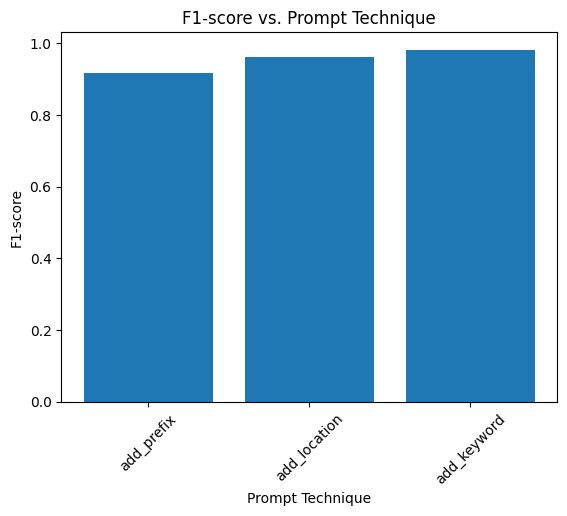

In [ ]:
# Visualize the F1-score for each prompt technique
plt.bar(prompt_techniques,f1_scores)
plt.title("F1-score vs. Prompt Technique")
plt.xlabel("Prompt Technique")
plt.ylabel("F1-score")
plt.xticks(range(len(prompt_techniques)), prompt_techniques, rotation=45)
plt.show()        